In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [ ]:
deliveries_path = "/content/deliveries.csv"
data = pd.read_csv(deliveries_path)


In [ ]:
# Preprocess data to calculate bowling performance metrics
bowler_data = data[['match_id', 'bowler', 'is_wicket', 'total_runs']]

In [ ]:
# Aggregate data by match and bowler
performance = bowler_data.groupby(['match_id', 'bowler']).agg(
    wickets=('is_wicket', 'sum'),  # Total wickets per match
    runs_conceded=('total_runs', 'sum')  # Total runs conceded per match
).reset_index()

In [ ]:
top_bowler = 'YS Chahal'
bowler_timeseries = performance[performance['bowler'] == top_bowler].set_index('match_id')['wickets']
print(bowler_timeseries)

match_id
598029     0
729281     1
729287     2
729299     1
729305     1
          ..
1426294    1
1426299    1
1426303    2
1426310    1
1426311    0
Name: wickets, Length: 159, dtype: int64


In [ ]:
# Aggregate performance metrics for each bowler across matches
bowler_summary = performance.groupby('bowler').agg(
    total_wickets=('wickets', 'sum'),
    total_runs_conceded=('runs_conceded', 'sum'),
    matches_played=('match_id', 'nunique')
).reset_index()


In [ ]:
# Calculate additional metrics
bowler_summary['average_runs_conceded'] = bowler_summary['total_runs_conceded'] / bowler_summary['matches_played']
bowler_summary['wickets_per_match'] = bowler_summary['total_wickets'] / bowler_summary['matches_played']



In [ ]:
# Sort bowlers by total wickets and select the top 10
top_bowlers = bowler_summary.sort_values(by='total_wickets', ascending=False).head(10)
top_bowlers

,bowler,total_wickets,total_runs_conceded,matches_played,average_runs_conceded,wickets_per_match
524,YS Chahal,213,4681,159,29.440252,1.339623
119,DJ Bravo,207,4436,158,28.075949,1.310127
348,PP Chawla,201,5179,191,27.115183,1.052356
446,SP Narine,200,4672,175,26.697143,1.142857
355,R Ashwin,198,5435,208,26.129808,0.951923
71,B Kumar,195,5051,176,28.698864,1.107955
438,SL Malinga,188,3486,122,28.573770,1.540984
8,A Mishra,183,4193,162,25.882716,1.129630
193,JJ Bumrah,182,3840,133,28.872180,1.368421
373,RA Jadeja,169,4917,211,23.303318,0.800948


In [ ]:
bowler_timeseries = bowler_timeseries.sort_index()


In [ ]:
model = ARIMA(bowler_timeseries, order=(2, 1, 2))  # ARIMA(p=2, d=1, q=2)
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

In [ ]:
# Forecast wickets for the next 10 matches
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


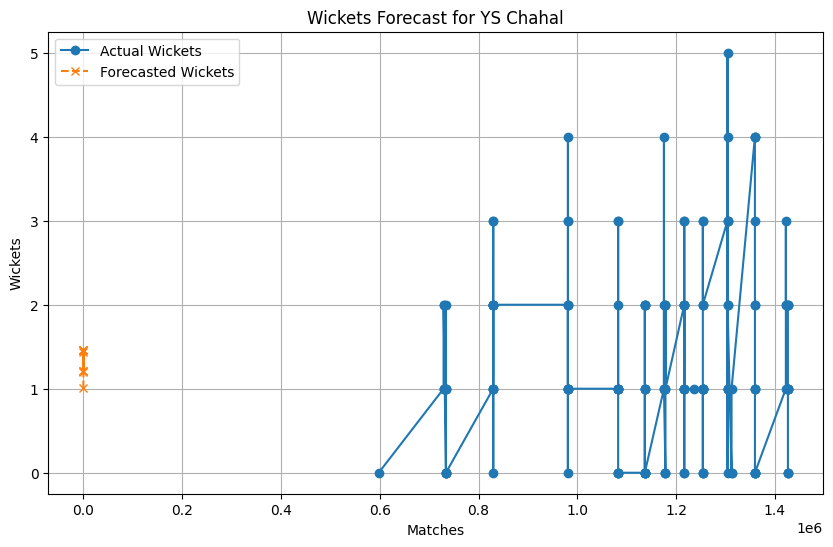

In [ ]:
# # Plot the actual vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(bowler_timeseries, label='Actual Wickets', marker='o')
plt.plot(range(len(bowler_timeseries), len(bowler_timeseries) + forecast_steps), forecast, label='Forecasted Wickets', marker='x', linestyle='--')
plt.title(f'Wickets Forecast for {top_bowler}')
plt.xlabel('Matches')
plt.ylabel('Wickets')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(f"Forecasted wickets for the next {forecast_steps} matches:")
print(forecast)

Forecasted wickets for the next 10 matches:
159    1.005454
160    1.437802
161    1.202628
162    1.464834
163    1.206342
164    1.465336
165    1.206418
166    1.465339
167    1.206425
168    1.465333
Name: predicted_mean, dtype: float64


In [ ]:
# Aggregate batting performance
batting_stats = (
    data.groupby('batter', as_index=False)
    .agg(
        total_runs=('batsman_runs', 'sum'),
        balls_faced=('ball', 'count'),
        matches_played=('match_id', 'nunique')
    )
)

In [ ]:
# Calculate strike rate
batting_stats['strike_rate'] = (batting_stats['total_runs'] / batting_stats['balls_faced']) * 100

In [ ]:
# Sort by total runs and strike rate to get top 10 batters
top_batters = batting_stats.sort_values(by=['total_runs', 'strike_rate'], ascending=[False, False]).head(10)
top_batters

,batter,total_runs,balls_faced,matches_played,strike_rate
631,V Kohli,8014,6236,244,128.511867
512,S Dhawan,6769,5483,221,123.454313
477,RG Sharma,6630,5183,251,127.918194
147,DA Warner,6567,4849,184,135.429986
546,SK Raina,5536,4177,200,132.535312
374,MS Dhoni,5243,3947,228,132.835065
30,AB de Villiers,5181,3487,170,148.580442
124,CH Gayle,4997,3516,141,142.121729
501,RV Uthappa,4954,3927,197,126.152279
282,KD Karthik,4843,3687,233,131.353404
